In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(n=4)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

rng_key = random.PRNGKey(seed=42)

In [2]:
class dgp_cuped:
    """
    Data Generating Process: CUPED
    """

    def __init__(self, alpha=5, beta=0, gamma=3, delta=2):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta

    def generate_data(self, N=100, seed=1):
        np.random.seed(seed)

        # Individuals
        i = range(1, N + 1)

        # Treatment status
        d = np.random.binomial(1, 0.5, N)

        # Individual outcome pre-treatment
        y0 = self.alpha + self.beta * d + np.random.normal(0, 1, N)
        y1 = y0 + self.gamma + self.delta * d + np.random.normal(0, 1, N)

        # Generate the dataframe
        df = pd.DataFrame({"i": i, "ad_campaign": d, "revenue0": y0, "revenue1": y1})

        return df

In [3]:
df = dgp_cuped().generate_data()
df.head()

,i,ad_campaign,revenue0,revenue1
0,1,0,5.315635,8.359304
1,2,1,2.977799,7.751485
2,3,0,4.693796,9.025253
3,4,0,5.827975,8.540667
4,5,0,5.230095,8.910165


In [4]:
(
    np.mean(df.loc[df.ad_campaign == True, "revenue1"])
    - np.mean(df.loc[df.ad_campaign == False, "revenue1"])
)

1.7914301325347406

In [5]:
ad_campaign = df.ad_campaign.to_numpy()
revenue0 = df.revenue0.to_numpy()
revenue1 = df.revenue1.to_numpy()

In [6]:
def cuped_model(ad_campaign, revenue0, revenue1):
    n_samples = len(ad_campaign)
    intercept_target = numpyro.sample("intercept_target", dist.Normal(0, 2))
    theta = numpyro.sample("theta", dist.Normal(0, 2))
    sigma_theta = numpyro.sample("sigma_theta", dist.HalfCauchy(2))

    mu_target = intercept_target + theta * revenue0

    with numpyro.plate("target_conditioning", n_samples):
        numpyro.sample(
            "revenue1_pred", dist.Normal(mu_target, sigma_theta), obs=revenue1
        )

    revenue_cuped = numpyro.deterministic(
        "revenue_cuped", revenue1 - theta * (revenue0 - jnp.mean(revenue0))
    )

    intercept_cuped = numpyro.sample("intercept_cuped", dist.Normal(0, 2))
    beta_cuped = numpyro.sample("beta_cuped", dist.Normal(0, 3))

    with numpyro.plate("cuped_conditioning", len(ad_campaign)):
        numpyro.sample(
            "revenue_cuped_pred",
            dist.Normal(intercept_cuped + beta_cuped * ad_campaign, 1),
            obs=revenue_cuped,
        )

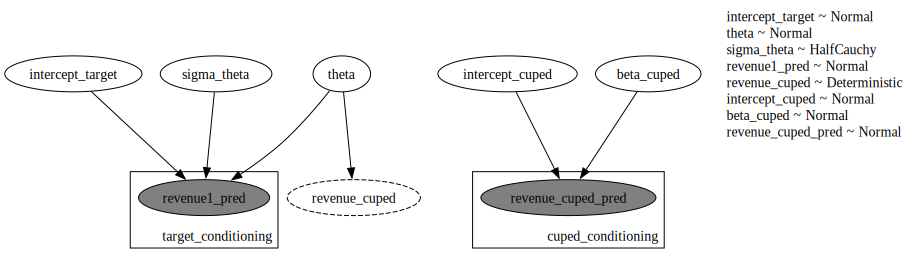

In [7]:
numpyro.render_model(
    cuped_model,
    model_args=(ad_campaign, revenue0, revenue1),
    render_distributions=True,
    render_params=True,
)

In [8]:
sampler = NUTS(cuped_model)
mcmc = MCMC(
    sampler=sampler,
    num_warmup=1_500,
    num_samples=2_000,
    num_chains=4,
)
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, ad_campaign, revenue0, revenue1)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

In [9]:
idata = az.from_numpyro(mcmc)

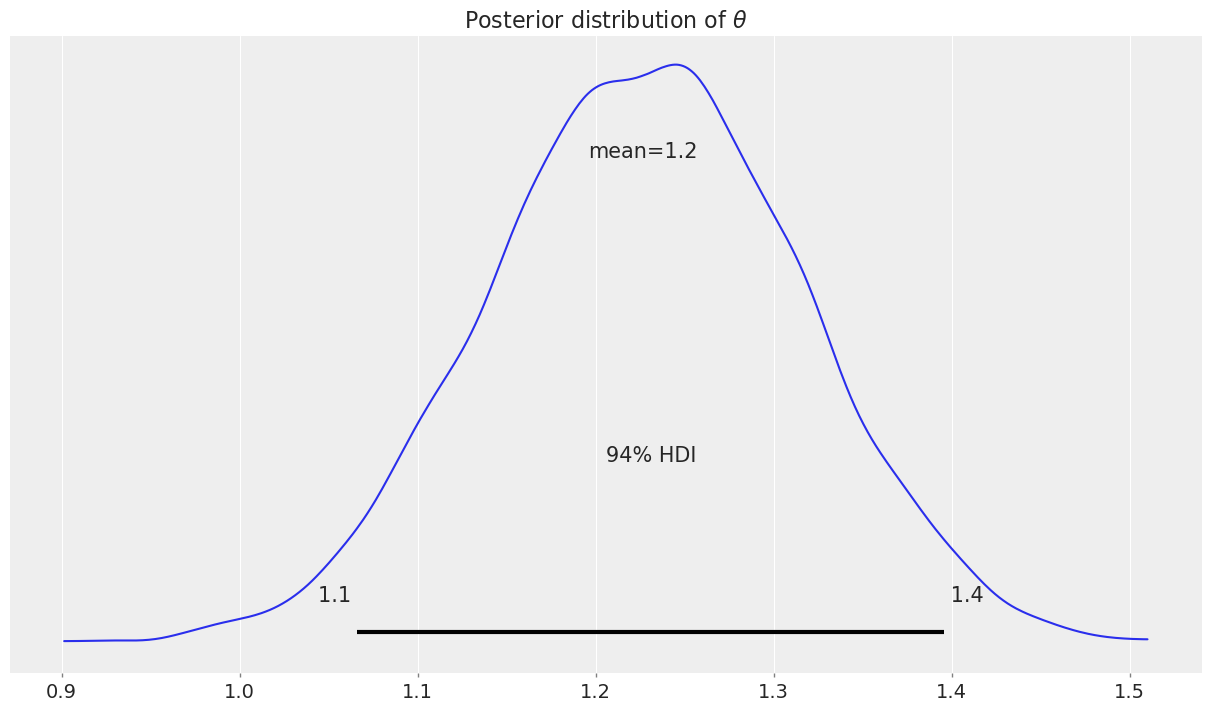

In [10]:
fig, ax = plt.subplots()
az.plot_posterior(idata, var_names=["theta"], ax=ax)
ax.set_title(r"Posterior distribution of $\theta$");

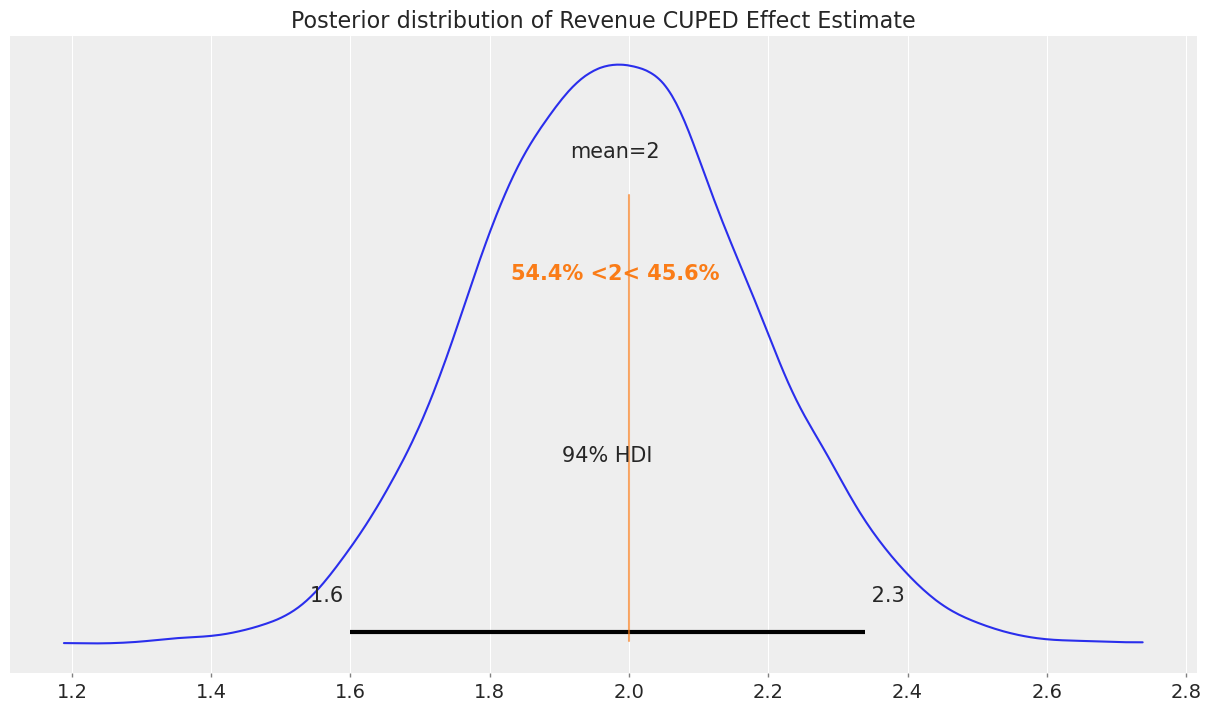

In [11]:
fig, ax = plt.subplots()
az.plot_posterior(idata, var_names=["beta_cuped"], ref_val=2.0, ax=ax)
ax.set_title("Posterior distribution of Revenue CUPED Effect Estimate");